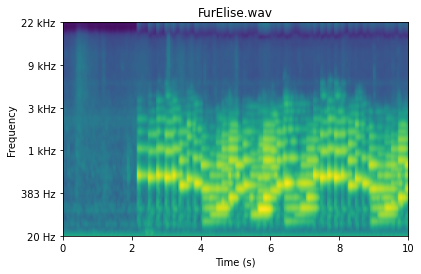

In [1]:
from os.path import join as pjoin
from gammatone.plot import render_audio_from_file
from gammatone.gtgram import gtgram
render_audio_from_file(pjoin("..", "data", "FurElise.wav"), 10, gtgram)

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def read_wav(path):
    from scipy.io import wavfile

    _f, _data = wavfile.read(path)  # samplerate, data
    _N = _data.shape[0]  # number of samples (overall)
    _t = 1.0 / _f  # period between samples (in seconds)
    _T = _t * _N  # overall length (in seconds)

    print(f"File: {path}\nSamples: {_N}, rate: {_f}s^-1, period: {_t:.10f}s, length: {_T}s")
    return {"data": _data, "f": _f, "N": _N, "T": _T}

def plot_wave(title, **kwargs):
    _data, _T, _N = kwargs["data"], kwargs["T"], kwargs["N"]

    _fig, (_ax1, _ax2) = plt.subplots(2, 1, figsize=(20, 5))
    _x = np.linspace(0., _T, _N)
    for _ax, _channel, _title in [(_ax1, 0, "Left channel"),
                                  (_ax2, 1, "Right channel")]:
        _ax.plot(_x, _data[:, _channel], label=_title, linewidth=0.1, color="#1ee1db")
        _ax.legend(loc="lower right")
        _ax.grid()
        _ax.set_xlabel("Time [s]")
        _ax.set_ylabel("Amplitude")
    plt.suptitle(title)

def plot_lowpass_butterworth_filter(title, **kwargs):
    from scipy import signal
    _data, _f, _T, _N = kwargs["data"], kwargs["f"], kwargs["T"], kwargs["N"]

    _nyq = _f / 2.  # Nyquist frequency = samplerate / 2
    _cutoff = 20000  # ~ maximum frequency heard by humans
    _order = 5

    _b, _a = signal.butter(_order, _cutoff / _nyq, btype="lowpass", output="ba")
    _filtered_data = signal.lfilter(_b, _a, _data)

    # Plot the filter frequency response
    _w, _h = signal.freqz(_b, _a)
    plt.plot(0.5*_f*_w/np.pi, np.abs(_h), color="blue")
    plt.plot(_cutoff, 0.5*np.sqrt(2), 'ko')
    plt.axvline(_cutoff, color="black")
    plt.xlim(0, 0.5*_f)
    plt.title("Lowpass Butterworth Filter Frequency Response")
    plt.xlabel('Frequency [Hz]')
    plt.grid()

    # Plot the filtered data
    ret_val = {"data": _filtered_data, "f": _f, "N": _N, "T": _T}
    plot_wave(title, **ret_val)
    return ret_val

def plot_fft(title, **kwargs):
    from scipy.fft import rfft
    _data, _N, _f = kwargs["data"], kwargs["N"], kwargs["f"]

    _fig, (_ax1, _ax2) = plt.subplots(1, 2, figsize=(20, 5))
    for _ax, _channel, _title in [(_ax1, 0, "Left channel"),
                                  (_ax2, 1, "Right channel")]:
        _yf = np.abs(rfft(_data[:, _channel]))
        _xf = np.linspace(0., _f/2., _yf.shape[0])
        _ax.plot(_xf, _yf, label=_title, linewidth=0.5, color="#1ee1db")
        _ax.legend(loc="upper right")
        _ax.grid()
        _ax.set_xlabel("Frequency [1/s]")
        _ax.set_ylabel("Amplitude")
    plt.suptitle(title)

File: ..\data\gallop\C5-A3-C5.wav
Samples: 116352, rate: 48000s^-1, period: 0.0000208333s, length: 2.424s


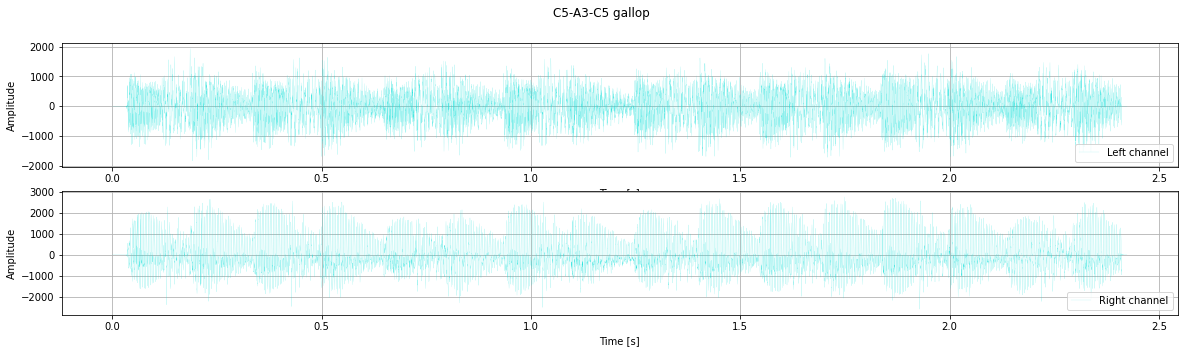

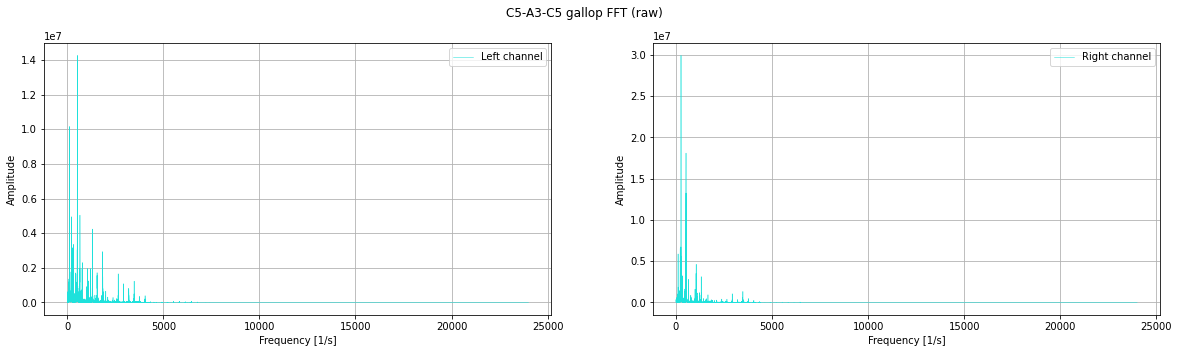

In [3]:
from os.path import join as pjoin
c5_a3_c5_raw = read_wav(pjoin("..", "data", "gallop", "C5-A3-C5.wav"))
plot_wave("C5-A3-C5 gallop", **c5_a3_c5_raw)
plot_fft("C5-A3-C5 gallop FFT (raw)", **c5_a3_c5_raw)

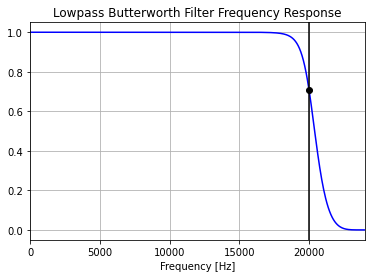

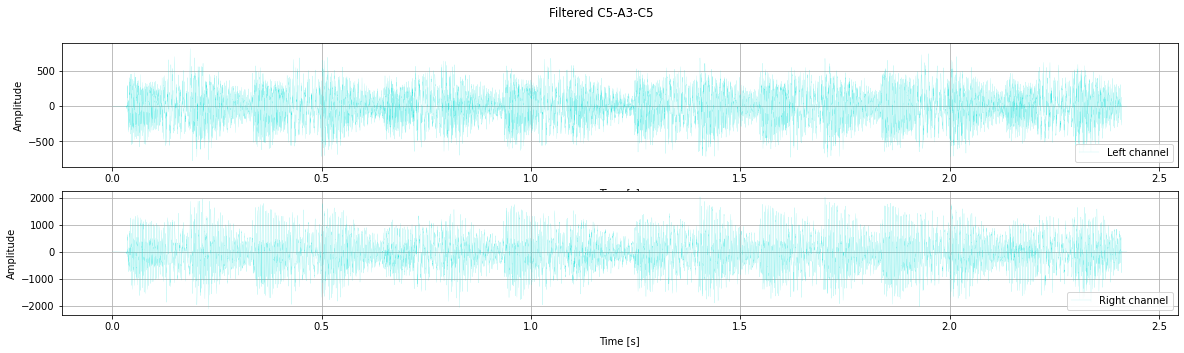

In [4]:
c5_a3_c5_lowpass_filtered = plot_lowpass_butterworth_filter("Filtered C5-A3-C5", **c5_a3_c5_raw)

In [5]:
from scipy.io import wavfile
from os.path import join as pjoin
samplerate, data = wavfile.read(pjoin("..", "data", "simultaneous", "C5-A3.wav"))
data = data[:, 0]
wavfile.write(pjoin("..", "data", "simultaneous", "C5-A3-left_channel.wav"), samplerate, data)

(array([40.2336978 , 22.59443991, 22.5944438 , ..., 22.59445028,
        22.5944438 , 22.59443991]),
 array([0.00000e+00, 2.00000e-04, 4.00000e-04, ..., 4.40994e+01,
        4.40996e+01, 4.40998e+01]) * khertz,
 array([ 0.        ,  3.14158728,  3.14158191, ..., -3.14157654,
        -3.14158191, -3.14158728]))

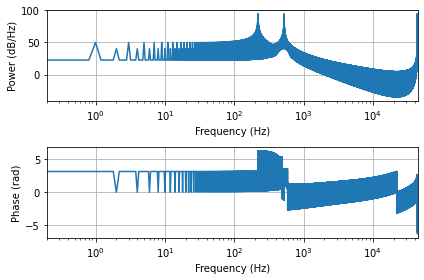

In [6]:
from brian2 import *
from brian2hears import *

sound_c5 = tone(523.25*Hz, .5*second)
sound_a3 = tone(220*Hz, .5*second)

sound = (Sound.sequence(sound_c5, sound_a3)).repeat(5)
sound = sound.ramp()
sound.spectrum(display=True)

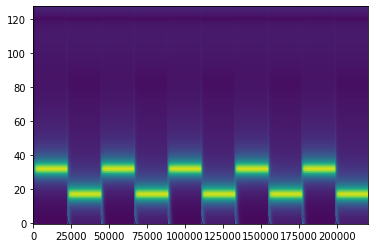

In [7]:
cf = erbspace(20*Hz, 20*kHz, 128)
gammatone = Gammatone(sound, cf)
cochlea = FunctionFilterbank(gammatone, lambda x: clip(x, 0, Inf)**(1.0/3.0))
lowpass = LowPass(cochlea, 10*Hz)
output = lowpass.process()

imshow(output.T, origin='lower', aspect='auto', vmin=0)
show()

In [8]:
sound.save(os.path.join("..", "data", "alternating", "C5-A3.wav"))

Duration: 3.97061224 s, nsamples: 175104, samplerate: 44.1 kHz
(512, 175104)


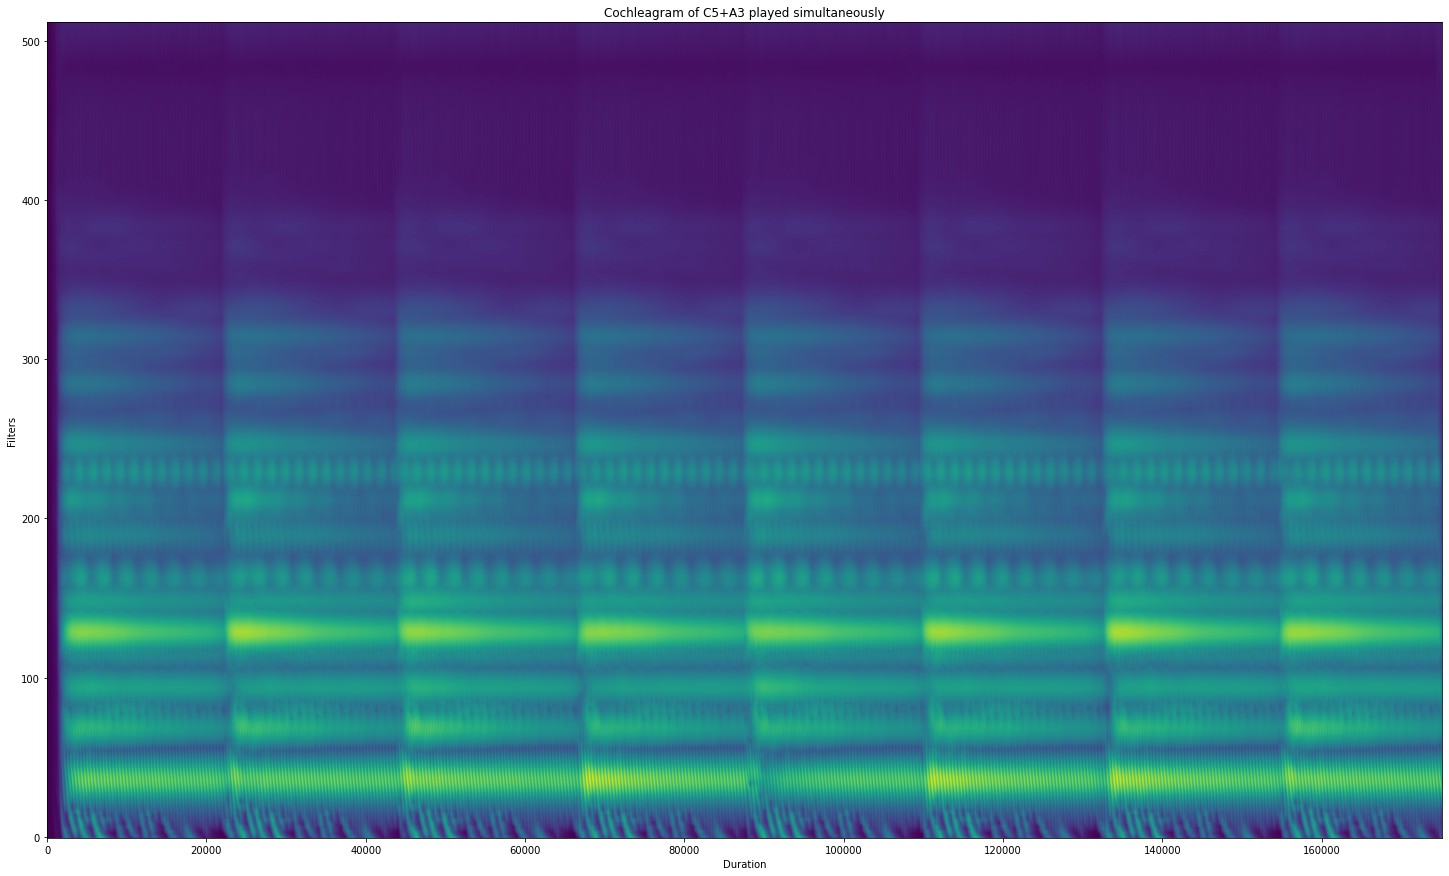

In [9]:
sound_c5_a3 = Sound.load(pjoin("..", "data", "simultaneous", "C5-A3.wav"))
cf = erbspace(20*Hz, 20*kHz, 512)
restructured = RestructureFilterbank(sound_c5_a3, indexmapping=[0])
gammatone = Gammatone(restructured, cf)
cochlea = FunctionFilterbank(gammatone, lambda x: clip(x, 0, Inf)**(1.0/3.0))
lowpass = LowPass(cochlea, 10*Hz)
output = lowpass.process().T
print(f"Duration: {sound_c5_a3.duration}, nsamples: {sound_c5_a3.nsamples}, "
      f"samplerate: {sound_c5_a3.nsamples / sound_c5_a3.duration}")
print(output.shape)
figure(figsize=(25, 15))
imshow(output, origin='lower', aspect='auto', vmin=0)
title("Cochleagram of C5+A3 played simultaneously")
xlabel("Duration")
ylabel("Filters")
show()

In [10]:
import skimage
samplerate = sound_c5_a3.nsamples / sound_c5_a3.duration
window_length_s = 10 * msecond
window_length = int(window_length_s * samplerate)
window_shape = (output.shape[0], window_length)
overlap_s = 5 * msecond
overlap = int(overlap_s * samplerate)

print(f"Applying windowing to {sound_c5_a3.nsamples} samples:\n"""
      f"Window: {window_length_s} ({window_length} samples), shape: {window_shape}\n"
      f"Overlap: {overlap_s} ({overlap} samples)\n")
windows = skimage.util.view_as_windows(output, window_shape, overlap).squeeze()
print(f"Shape of the result: {windows.shape}\nFirst window {windows[0].shape}:\n{windows[0]}")

Applying windowing to 175104 samples:
Window: 10. ms (441 samples), shape: (512, 441)
Overlap: 5. ms (220 samples)

Shape of the result: (794, 512, 441)
First window (512, 441):
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.00132212 0.0013407  0.00133879]
 [0.         0.         0.         ... 0.0013555  0.0013762  0.00137424]
 [0.         0.         0.         ... 0.00131294 0.00133463 0.00133273]]


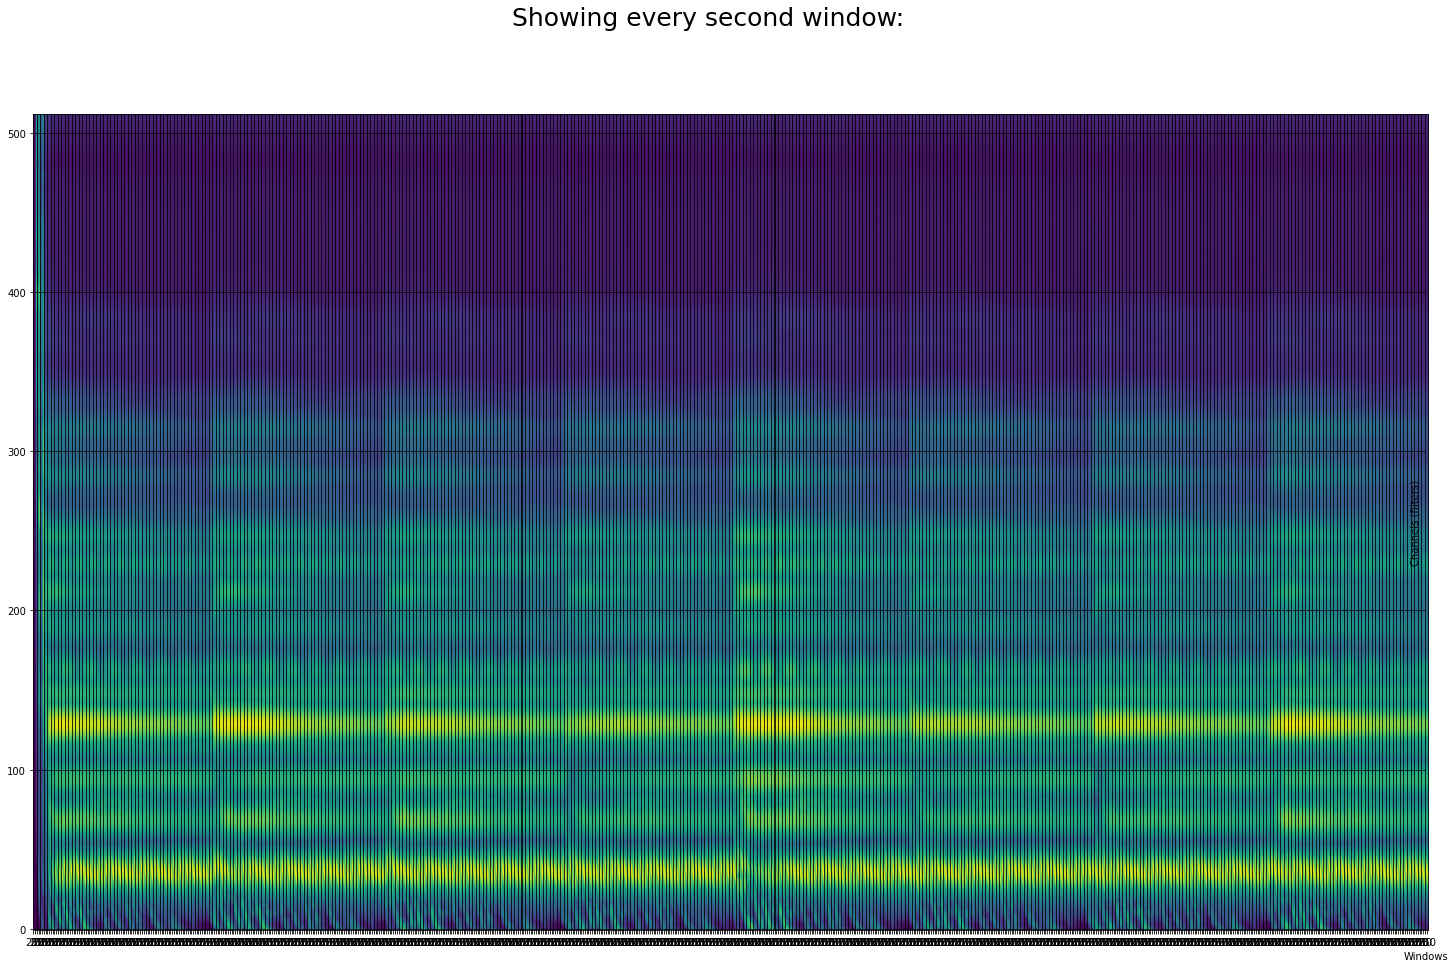

In [11]:
windows_to_plot = windows[::2]
fig, axs = plt.subplots(ncols=windows_to_plot.shape[0], sharey="all", figsize=(25, 15))
subplots_adjust(wspace=.001)
suptitle("Showing every second window:", fontsize=25)
xlabel("Windows")
ylabel("Channels (filters)")
for i, ax in enumerate(axs):
    ax.imshow(windows_to_plot[i], origin='lower', aspect='auto', vmin=0)

Shape of the RMS'ed windows: (512, 794)


Text(0, 0.5, 'Channels (filters)')

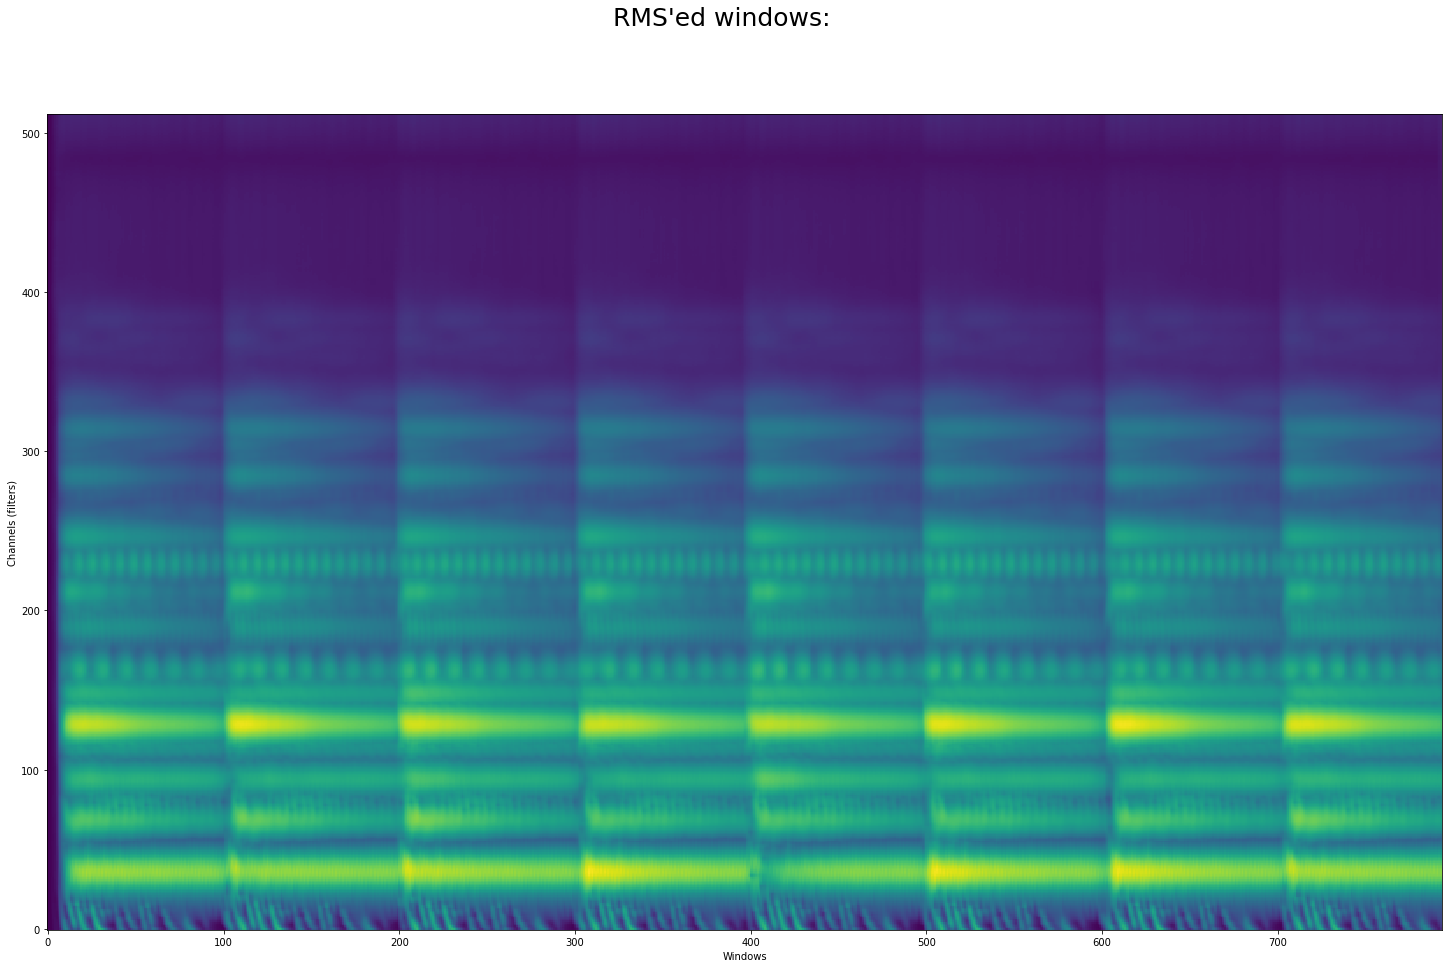

In [12]:
rmsed = np.apply_along_axis(lambda vec: np.sqrt(np.mean(np.square(vec))), 2, windows).T

print(f"Shape of the RMS'ed windows: {rmsed.shape}")
figure(figsize=(25, 15))
imshow(rmsed, origin='lower', aspect='auto', vmin=0, interpolation="none")

suptitle("RMS'ed windows:", fontsize=25)
xlabel("Windows")
ylabel("Channels (filters)")

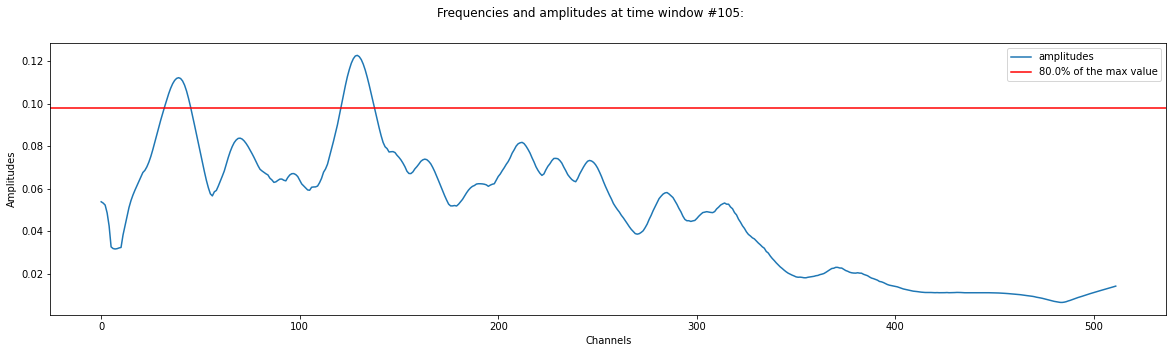

In [13]:
window_num = 105
threshold = 0.8
freqs = rmsed[:, window_num]

figure(figsize=(20, 5))
plot(freqs, label="amplitudes")
axhline(freqs.max() * threshold, color="red", label=f"{threshold * 100}% of the max value")
suptitle(f"Frequencies and amplitudes at time window #{window_num}:")
xlabel("Channels")
ylabel("Amplitudes")
legend()

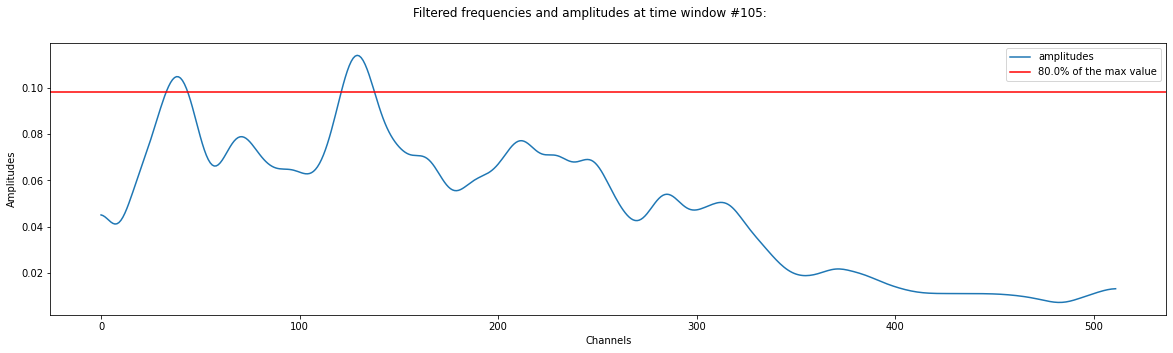

In [14]:
from scipy.ndimage import gaussian_filter
sigma = 5
filtered_window = gaussian_filter(freqs, sigma)

figure(figsize=(20, 5))
plot(filtered_window, label="amplitudes")
axhline(freqs.max() * threshold, color="red", label=f"{threshold * 100}% of the max value")
suptitle(f"Filtered frequencies and amplitudes at time window #{window_num}:")
xlabel("Channels")
ylabel("Amplitudes")
legend()

Shape of the filtered windows: (512, 794)


Text(0, 0.5, 'Channels (filters)')

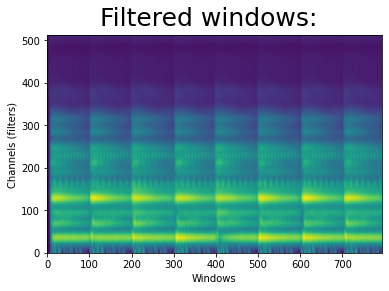

In [15]:
filtered = np.apply_along_axis(lambda vec: gaussian_filter(vec, sigma), 0, rmsed)

print(f"Shape of the filtered windows: {filtered.shape}")
imshow(filtered, origin='lower', aspect='auto', vmin=0, interpolation="none")

suptitle("Filtered windows:", fontsize=25)
xlabel("Windows")
ylabel("Channels (filters)")

Shape of the mask: (512, 794)


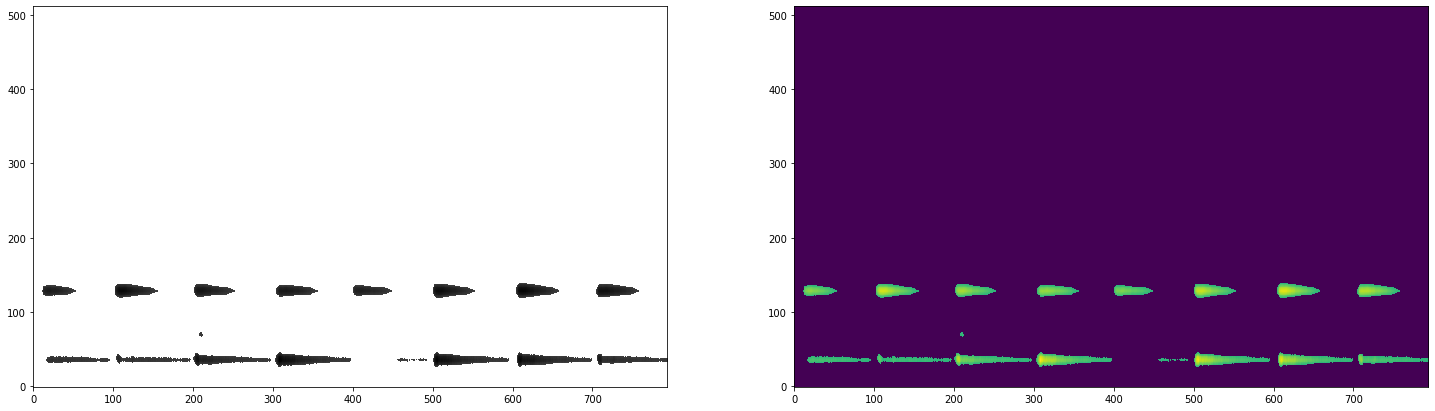

In [16]:
def cutoff(vec):
    result = vec
    result[result < threshold * freqs.max()] = 0
    return result
mask = np.apply_along_axis(cutoff, 0, filtered)
mask /= mask.max()

print(f"Shape of the mask: {mask.shape}")
fig, (ax1, ax2) = subplots(ncols=2, figsize=(25, 7))
ax1.imshow(mask, origin='lower', aspect='auto', vmin=0, interpolation="none", cmap="Greys")
ax2.imshow(np.multiply(filtered, mask), origin='lower', aspect='auto', vmin=0, interpolation="none")